In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gradientDescent import gradientDescent
from alternatingLeastSquares import ALS
from cost_functions import *

In [2]:
np.random.seed(0)

In [3]:
alpha = 1e-3
tol = 1e-3
max_iter = 10_000

In [4]:
R = np.array(
    [
        [5, 1, np.NAN, 4],
        [np.NAN, 9, np.NAN, 2],
        [9, 2, 1, np.NAN],
        [6, np.NAN, 7, 4],
        [np.NAN, 4, 7, 5],
    ]
)

In [5]:
p = 4

In [6]:
Theta = initializeTheta(R.shape[0], p)
X = initializeX(R.shape[1], p)

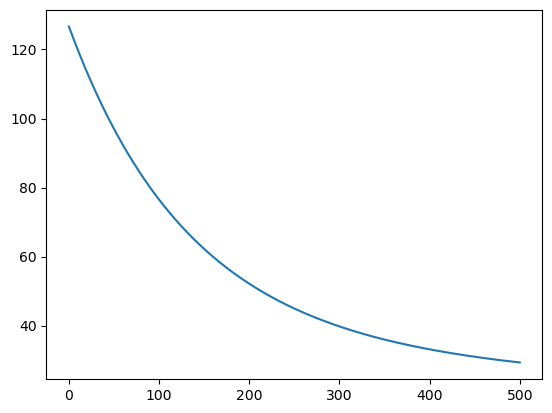

In [7]:
Ju, DJu = get_Ju_and_DJu(R, X)

newThetaResults = gradientDescent(Ju, Theta, DJu, alpha, tol, max_iter)
newTheta = newThetaResults["parameters"]
Ju_values = newThetaResults["func_values"]

plt.plot(Ju_values)
plt.show()

In [8]:
newR = newTheta @ X.T

In [9]:
pd.DataFrame(np.around(newR, 2))

,0,1,2,3
0,4.31,2.52,2.75,2.46
1,5.42,4.81,4.08,3.66
2,5.77,2.94,3.59,3.07
3,6.57,4.23,4.33,3.98
4,6.40,4.84,4.54,3.98


In [10]:
pd.DataFrame(R)

,0,1,2,3
0,5.0,1.0,NaN,4.0
1,NaN,9.0,NaN,2.0
2,9.0,2.0,1.0,NaN
3,6.0,NaN,7.0,4.0
4,NaN,4.0,7.0,5.0


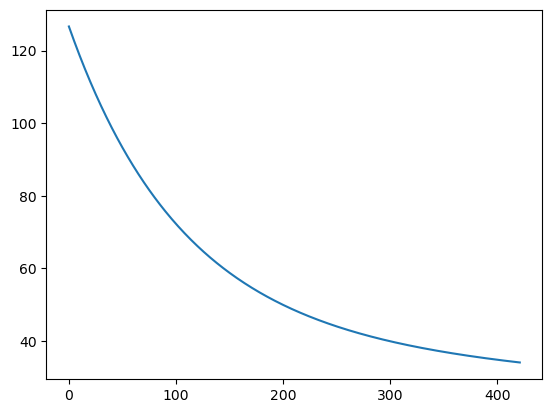

In [11]:
Ja, DJa = get_Ja_and_DJa(R, Theta)

newXResults = gradientDescent(Ja, X, DJa, alpha, tol, max_iter)
newX = newXResults["parameters"]
Ja_values = newXResults["func_values"]

plt.plot(Ja_values)
plt.show()

In [12]:
newR = Theta @ newX.T

In [13]:
pd.DataFrame(np.around(newR, 2))

,0,1,2,3
0,5.93,3.46,4.22,3.51
1,5.65,4.11,4.37,3.57
2,6.79,3.18,3.69,3.38
3,4.61,2.20,3.58,2.83
4,5.44,4.43,4.87,3.83


In [14]:
pd.DataFrame(R)

,0,1,2,3
0,5.0,1.0,NaN,4.0
1,NaN,9.0,NaN,2.0
2,9.0,2.0,1.0,NaN
3,6.0,NaN,7.0,4.0
4,NaN,4.0,7.0,5.0


In [15]:
np.random.seed(0)
als_result = ALS(R, p, alpha, 0, tol, 10, max_iter)

In [16]:
newTheta = als_result["Theta"]
newX = als_result["X"]
J_values = als_result["J_values"]

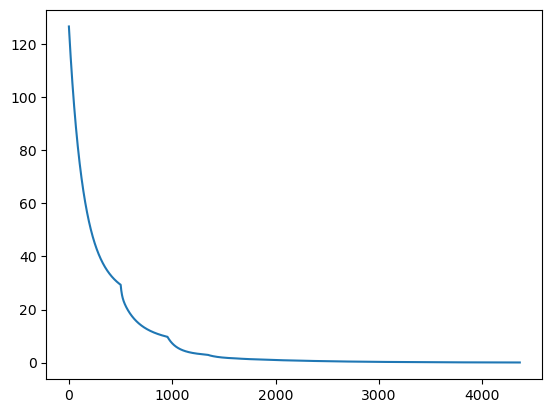

In [17]:
plt.plot(J_values)
plt.show()

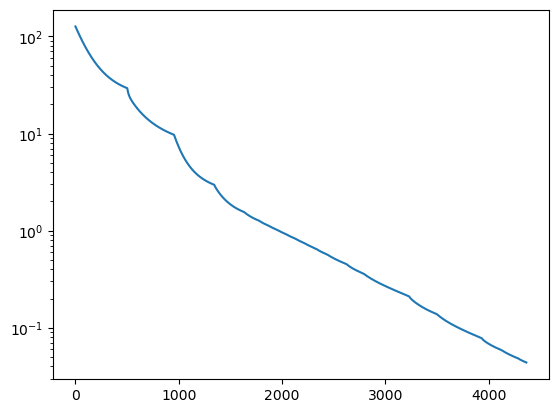

In [18]:
plt.plot(J_values)
plt.yscale("log")
plt.show()

In [19]:
newR = newTheta @ newX.T

In [20]:
pd.DataFrame(np.around(newR, 1))

,0,1,2,3
0,5.1,1.0,1.9,3.9
1,4.2,9.0,12.7,2.0
2,9.0,1.9,1.0,6.1
3,5.9,4.2,7.0,4.1
4,7.2,4.1,6.9,5.0


In [21]:
pd.DataFrame(R)

,0,1,2,3
0,5.0,1.0,NaN,4.0
1,NaN,9.0,NaN,2.0
2,9.0,2.0,1.0,NaN
3,6.0,NaN,7.0,4.0
4,NaN,4.0,7.0,5.0
